In [3]:

import nle.dataset as nld
from nle.nethack import tty_render
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.stats import ttest_ind


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from nle.dataset import db


In [4]:
# path to dataset
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

# name database
dbfilename = "nld-nao.db"

# name dataset
dataset_name = "nld-nao"

# connect database to 
db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [5]:
# Build the subselect sql query
subselect_sql = "SELECT gameid FROM games WHERE death = ?"
subselect_sql_args = ("ascended",)

# Build the dataset
ascended_trajectories = nld.TtyrecDataset(
    "nld-nao",
    batch_size=10,
    seq_length=32,
    dbfilename=dbfilename,
    subselect_sql=subselect_sql,
    subselect_sql_args=subselect_sql_args
)

# See from the error how there are fewer than 10k games despite the full dataset having 109k
print(f"Ascended Player Dataset Has: {len(ascended_trajectories._gameids)}")

minibatch = next(iter(ascended_trajectories))
minibatch.keys()

Ascended Player Dataset Has: 22071


dict_keys(['tty_chars', 'tty_colors', 'tty_cursor', 'timestamps', 'done', 'gameids'])

In [6]:
batch_idx = 0
max_time_index = 69025
time_idx = 17
#  GameID 1757932
# Need to find a better way to define an entire sequence of games
# Observation Example and Corresponding Metadata

chars = minibatch['tty_chars'][batch_idx, time_idx]
colors = minibatch['tty_colors'][batch_idx, time_idx]
cursor = minibatch['tty_cursor'][batch_idx, time_idx]

game_id = minibatch['gameids'][batch_idx, time_idx]


print(tty_render(chars, colors, cursor))
dict(ascended_trajectories.get_meta(game_id))


                                                                                
                                                                                
                                                                                
                                                                                
                                             ------------                       
                                             |..........|                       
                                             ...........|                       
                                             |..........|                       
                                             |....@.....|                       
                                             ....<.u....|                       
                                             ---.--------                       
                                                                                
                           

{'gameid': 2065248,
 'version': '3.6.1',
 'points': 3603506,
 'deathdnum': 7,
 'deathlev': -5,
 'maxlvl': 48,
 'hp': 475,
 'maxhp': 475,
 'deaths': 1,
 'deathdate': 20180924,
 'birthdate': 20180922,
 'uid': 5,
 'role': 'Kni',
 'race': 'Hum',
 'gender': 'Mal',
 'align': 'Law',
 'name': 'Player2391',
 'death': 'ascended',
 'conduct': '0x500',
 'turns': 47088,
 'achieve': '0xbff',
 'realtime': 76520,
 'starttime': 1537606756,
 'endtime': 1537749012,
 'gender0': 'Mal',
 'align0': 'Law',
 'flags': '0x0'}

In [6]:
import re

def parse_output(output):
 lines = output.split('\n')
 message = []
 map = []
 status = []

 map_start = False
 for line in lines:
     if line.strip() == "":
         continue
     if re.match(r"^[A-Za-z]", line):
         message.append(line)
     elif "St:" in line:
         status.append(line)
     else:
         map.append(line)
 
 return {
     "message": "\n".join(message),
     "map": "\n".join(map),
     "status": "\n".join(status)
 }


output = ""

In [8]:
# Ascended Dataframe of 500 players
# Build the subselect sql query

subselect_sql = """
SELECT * 
FROM games 
WHERE name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) = 1)"""


df = pd.read_sql(subselect_sql, db_conn)  



column_to_move = 'name'
new_columns_order = [column_to_move] + [col for col in df.columns if col != column_to_move]
# Reorder the dataframe columns
df = df[new_columns_order] 
# Sorting by the 'name' column
df = df.sort_values(by='name')



# Group by player name and select the first 500 unique players
first_ten_players = df['name'].unique()[:500]

# Filter the original DataFrame to include only the first ten players
ascended_df = df[df['name'].isin(first_ten_players)]

ascended_df.to_csv('df.csv', index=False)  

# Display the DataFrame with the first ten players
ascended_df 


,name,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,...,death,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags
48421,Player0,3521212,3.4.3,5,7,-5,1,10,10,0,...,ascended,0xdff,1,0x1e0,43,1206301148,1206301198,Fem,Neu,-1
43763,Player0,2780724,3.6.0,37,0,1,1,-1,10,1,...,killed by a newt,0xfff,186,0x0,100,1464595898,1509394897,Fem,Neu,0x4
70735,Player0,3827696,3.4.3,78,0,2,2,0,16,1,...,killed by a grid bug,0xfcf,237,0x0,133,1236079386,1247770346,Mal,Law,-1
48354,Player0,3520378,3.4.3,0,0,1,1,0,10,1,...,killed by kicking a wall,0xfff,52,0x0,30,1206144424,1206144460,Fem,Neu,-1
48355,Player0,3520380,3.4.3,0,0,1,1,-1,11,1,...,killed by kicking a wall,0xfff,10,0x0,125,1206144463,1206144590,Mal,Cha,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48990,Player30355,3529478,3.4.3,5934,2,7,7,-8,46,1,...,killed by a dwarf,0xfc0,3166,0x0,3771,1207527203,1207530998,Fem,Cha,-1
140445,Player30355,6341143,3.4.3,263,0,2,2,-5,13,1,...,killed by a gas spore's explosion,0xfc8,988,0x0,2605,1448782937,1448852642,Fem,Cha,0x0
49918,Player30355,3541949,3.4.3,8534,0,4,8,-1,60,1,...,poisoned by an orcish arrow,0xf88,5209,0x0,7466,1208975827,1208992293,Fem,Cha,-1
140075,Player30355,6334290,3.4.3,20067,0,9,10,-8,77,1,...,killed by a water elemental,0xfc0,6070,0x0,8996,1448159958,1448169010,Mal,Law,0x20


In [8]:
# Build the subselect sql query
subselect_sql = """
SELECT *
FROM games
WHERE name NOT IN (
    SELECT name
    FROM games
    WHERE death = 'ascended'
)"""

df = pd.read_sql(subselect_sql, db_conn)  
column_to_move = 'name'
new_columns_order = [column_to_move] + [col for col in df.columns if col != column_to_move]
# Reorder the dataframe columns
df = df[new_columns_order] 
# Sorting by the 'name' column
df = df.sort_values(by='name')
# Group by player name and select the first ten unique players
first_ten_players = df['name'].unique()[:10]

# Filter the original DataFrame to include only the first ten players
non_ascended_df = df[df['name'].isin(first_ten_players)]

print(non_ascended_df)



               name   gameid version  points  deathdnum  deathlev  maxlvl  \
0           Player1        3   3.6.3     330          0         4       5   
584589      Player1  4370818   3.4.3    5128          2         6       6   
584566      Player1  4370743   3.4.3   14245          2         6       8   
584455      Player1  4370124   3.4.3   53867          0         8      12   
583998      Player1  4368161   3.4.3     303          0         3       3   
...             ...      ...     ...     ...        ...       ...     ...   
211896  Player10008  2315956   3.6.0    4132          4         4       6   
247652  Player10008  2446065   3.6.0     117          0         1       1   
211899  Player10008  2315966   3.6.0      83          0         1       1   
317448  Player10008  2799523   3.6.0     102          0         2       2   
105827  Player10009  1901965   3.6.3  684080          1        39      39   

         hp  maxhp  deaths  ...                           death  conduct  \

In [9]:
# Print column names
print("Column names:", ascended_df.columns.tolist())
ascended_df.describe()

Column names: ['name', 'gameid', 'version', 'points', 'deathdnum', 'deathlev', 'maxlvl', 'hp', 'maxhp', 'deaths', 'deathdate', 'birthdate', 'uid', 'role', 'race', 'gender', 'align', 'death', 'conduct', 'turns', 'achieve', 'realtime', 'starttime', 'endtime', 'gender0', 'align0', 'flags']


,gameid,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,birthdate,uid,turns,realtime,starttime,endtime
count,2.445000e+03,2.445000e+03,2445.000000,2445.000000,2445.00000,2445.000000,2445.000000,2445.000000,2.445000e+03,2.445000e+03,2445.000000,2445.000000,2.445000e+03,2.445000e+03,2.445000e+03
mean,4.009434e+06,2.435073e+04,0.748875,4.268712,5.13865,2.377096,33.492025,0.938650,2.012204e+07,2.012195e+07,4.977505,3019.634765,2.714181e+04,1.345091e+09,1.345380e+09
std,1.211962e+06,2.376920e+05,1.179095,3.512571,5.00932,25.981410,35.570940,0.364549,2.986646e+04,2.983704e+04,0.334685,6699.386856,2.616090e+05,9.503069e+07,9.514150e+07
min,1.902240e+06,0.000000e+00,0.000000,-5.000000,1.00000,-32.000000,1.000000,0.000000,2.008032e+07,2.008032e+07,0.000000,1.000000,4.000000e+00,1.205982e+09,1.205987e+09
25%,3.523436e+06,2.080000e+02,0.000000,2.000000,2.00000,-3.000000,12.000000,1.000000,2.010022e+07,2.010022e+07,5.000000,561.000000,3.430000e+02,1.266704e+09,1.266710e+09
50%,3.977455e+06,6.920000e+02,0.000000,4.000000,4.00000,-1.000000,21.000000,1.000000,2.011103e+07,2.011103e+07,5.000000,1411.000000,1.023000e+03,1.319740e+09,1.319794e+09
75%,4.748304e+06,2.682000e+03,2.000000,6.000000,6.00000,0.000000,45.000000,1.000000,2.015112e+07,2.015111e+07,5.000000,2871.000000,3.306000e+03,1.447330e+09,1.447548e+09
max,6.374622e+06,4.322466e+06,7.000000,45.000000,53.00000,528.000000,607.000000,7.000000,2.020090e+07,2.019111e+07,5.000000,92597.000000,6.971478e+06,1.573267e+09,1.599226e+09


In [10]:
# Extract the points column from both DataFrames
points_win = ascended_df['points']
points_lose = non_ascended_df['points']

# Perform t-test
t_stat, p_value = ttest_ind(points_win, points_lose)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

ascended_df.describe()
non_ascended_df.describe()

T-statistic: 2.3903189047343343
P-value: 0.016885638735369943


,gameid,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,birthdate,uid,turns,realtime,starttime,endtime
count,1.103000e+03,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1.103000e+03,1.103000e+03,1103.0,1103.000000,1.103000e+03,1.103000e+03,1.103000e+03
mean,3.018444e+06,7137.435177,0.916591,5.195830,5.742520,2.733454,43.553944,0.911151,2.014911e+07,2.014895e+07,5.0,2913.891206,1.817560e+04,1.432424e+09,1.432918e+09
std,1.657015e+06,39205.649684,1.156661,3.581524,3.691959,18.007098,26.122956,0.306157,3.885374e+04,3.874524e+04,0.0,5625.255847,2.699123e+05,1.191959e+08,1.194933e+08
min,3.000000e+00,0.000000,0.000000,1.000000,1.000000,-32.000000,4.000000,0.000000,2.010073e+07,2.010073e+07,5.0,6.000000,1.100000e+01,1.280478e+09,1.280481e+09
25%,2.104828e+06,392.500000,0.000000,3.000000,4.000000,-2.000000,21.500000,1.000000,2.011022e+07,2.011022e+07,5.0,769.000000,7.075000e+02,1.298620e+09,1.298645e+09
50%,2.800213e+06,1407.000000,0.000000,5.000000,5.000000,0.000000,41.000000,1.000000,2.016052e+07,2.016052e+07,5.0,1596.000000,1.830000e+03,1.463553e+09,1.463640e+09
75%,4.363213e+06,3698.500000,2.000000,6.000000,7.000000,0.000000,60.000000,1.000000,2.018123e+07,2.018122e+07,5.0,3173.500000,6.243500e+03,1.545767e+09,1.545989e+09
max,6.418133e+06,913016.000000,4.000000,39.000000,39.000000,237.000000,237.000000,2.000000,2.021033e+07,2.020111e+07,5.0,113102.000000,8.322799e+06,1.604989e+09,1.617114e+09


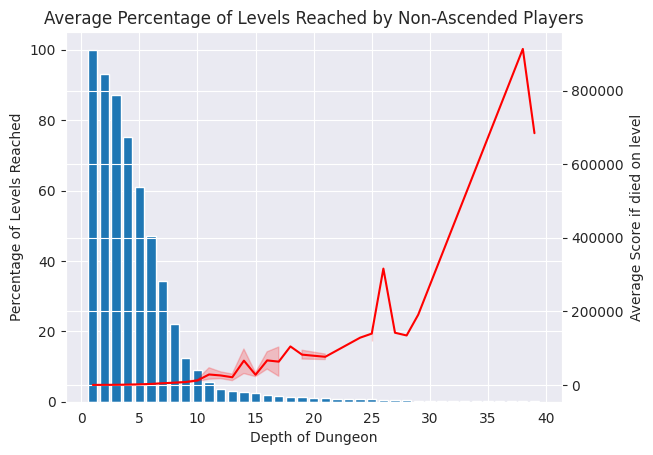

In [11]:
# Example 
levels_reached = non_ascended_df["maxlvl"]
depths = sorted(set(range(1, max(levels_reached) + 1)))
percentage = [sum(1 for level in levels_reached if level >= depth) / len(levels_reached) * 100 for depth in depths]

fig, ax1 = plt.subplots()
ax1.bar(depths, percentage)
ax1.set_xlabel("Depth of Dungeon")
ax1.set_ylabel("Percentage of Levels Reached")

# Create second plot with seaborn
ax2 = ax1.twinx()
ax2.set_ylabel("Average Score if died on level")
sns.lineplot(non_ascended_df, x="maxlvl", y="points", color="red", errorbar=('ci', 90), ax=ax2)

plt.title(f"Average Percentage of Levels Reached by Non-Ascended Players")
plt.show()

In [9]:
# subselect_sql = "SELECT gameid, MAX(starttime) - MIN(starttime) AS starttime_diff FROM games GROUP BY name ORDER BY starttime_diff DESC"
# subselect_sql_args = ("Mon", "Hum")
# 
# # Can change these as needed
# batch_size = 10
# seq_length = 32
# 
# 
# # Build the dataset
# data = nld.TtyrecDataset(
#     "nld-nao",
#     batch_size=batch_size,
#     seq_length=seq_length,
#     dbfilename=dbfilename,
#     subselect_sql=subselect_sql 
#     # subselect_sql_args=subselect_sql_args
# )

# # Build the subselect sql query
# subselect_sql = """
# SELECT gameid, MAX(starttime) - MIN(starttime) AS starttime_diff 
# FROM games 
# GROUP BY name 
# ORDER BY starttime_diff DESC"""


ascend_sql = """
SELECT
    *,
    MAX(endtime) - MIN(starttime) AS time_difference
FROM
    games
WHERE 
    name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) = 1)
GROUP BY
    name
ORDER BY
    time_difference DESC
    """


data = pd.read_sql(ascend_sql, db_conn)
data

# data.sort_values(by='games_played')

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference
0,3631949,3.4.3,10267,0,8,8,-2,50,1,20080826,...,0xf80,4502,0x0,16855,1206851852,1219736936,Mal,Cha,-1,437931885
1,3519458,3.4.3,18203,2,12,12,-12,66,1,20080320,...,0xf90,5680,0x0,4400,1205970140,1205974583,Mal,Law,-1,436170216
2,3528984,3.4.3,4631,2,5,5,-5,73,1,20080406,...,0xf80,3126,0x0,2595,1207446383,1207449513,Fem,Law,-1,428805040
3,3519822,3.4.3,267,2,3,3,-1,13,1,20080320,...,0xfbf,356,0x0,383,1206044229,1206044620,Mal,Neu,-1,426781272
4,3523421,3.4.3,63003,2,10,10,-3,104,1,20080326,...,0xe80,19593,0x400,108765,1206026186,1206568188,Mal,Cha,-1,421065132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,3964991,3.4.3,2366444,7,-5,47,222,222,0,20100204,...,0x108,18775,0x5ff,16466,1265266516,1265282983,Fem,Cha,-1,23182
1538,4917736,3.4.3,1425714,7,-5,48,126,126,0,20120407,...,0x500,18786,0x7ff,15106,1333774525,1333789692,Mal,Cha,0x20,16997
1539,6032666,3.4.3,1542910,7,-5,50,293,293,0,20140314,...,0x0,19360,0x3ff,14501,1394768196,1394782707,Mal,Neu,0x0,16373
1540,6079560,3.4.3,1176406,7,-5,50,105,109,0,20140605,...,0x0,22965,0xfff,11585,1401942296,1401953891,Mal,Neu,0x20,11595


In [10]:
subselect_sql = """
SELECT * 
FROM games 
WHERE name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) = 1)"""


df = pd.read_sql(subselect_sql, db_conn)  

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# print(time_diff.sort_values(by='time_difference', ascending=False))


# Merge the original DataFrame with the time difference DataFrame
df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first ten unique players
first_ten_players = df['name'].unique()[:3]
# Filter the original DataFrame to include only the first ten players
ascended_df = df[df['name'].isin(first_ten_players)]

ascended_df = ascended_df.sort_values(by=['name','starttime'])
# Drop the column
ascended_df = ascended_df.drop('min_starttime', axis=1)
ascended_df = ascended_df.drop('max_endtime', axis=1)



ascended_df
# column_to_move = 'name'
# new_columns_order = [column_to_move] + [col for col in df.columns if col != column_to_move]
# # Reorder the dataframe columns
# df = df[new_columns_order] 
# # Sorting by the 'name' column
# df = df.sort_values(by='name')





,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference
8687,1808261,3.6.3,40,0,1,1,0,11,1,20190813,...,0xf8f,501,0x0,534,1565705028,1565705566,Mal,Cha,0x4,39453278
8702,1808709,3.6.3,16,0,1,1,13,13,0,20190813,...,0xfff,249,0x0,16480,1565715680,1565737291,Fem,Neu,0x4,39453278
8703,1808731,3.6.3,278,0,2,2,0,42,1,20190814,...,0xfc8,934,0x0,4336,1565737317,1565741660,Fem,Law,0x4,39453278
8725,1809148,3.6.3,512,0,4,5,0,43,1,20190814,...,0xe88,2195,0x0,20877,1565741720,1565792929,Fem,Law,0x4,39453278
8726,1809170,3.6.3,811,0,5,5,0,42,1,20190814,...,0xfc8,2108,0x0,2859,1565793013,1565795962,Fem,Law,0x0,39453278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5941,248356,3.6.6,0,0,1,1,14,14,0,20201014,...,0xfbf,67,0x0,13,1602662722,1602662736,Fem,Neu,0x4,77095022
5942,248361,3.6.6,636,0,4,4,0,30,1,20201014,...,0xfc0,1881,0x0,1682,1602662760,1602664443,Fem,Neu,0x4,77095022
6005,249674,3.6.6,616,2,5,5,0,26,1,20201015,...,0xfc0,1873,0x0,1363,1602771834,1602773198,Fem,Neu,0x0,77095022
6006,249679,3.6.6,24,0,1,1,14,14,0,20201015,...,0xfcf,11,0x0,14,1602773244,1602773258,Fem,Neu,0x4,77095022


In [11]:
# Build the subselect sql query
subselect_sql = """
SELECT *
FROM games
WHERE name NOT IN (
    SELECT name
    FROM games
    WHERE death = 'ascended'
)"""

df = pd.read_sql(subselect_sql, db_conn) 

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime'] 

df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first ten unique players
first_ten_players = df['name'].unique()[:5]
# Filter the original DataFrame to include only the first ten players
non_ascended_df = df[df['name'].isin(first_ten_players)]

non_ascended_df = non_ascended_df.drop('min_starttime', axis=1)
non_ascended_df = non_ascended_df.drop('max_endtime', axis=1)

non_ascended_df

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference
0,3,3.6.3,330,0,4,5,0,14,1,20191206,...,0xfc8,596,0x0,596,1575644417,1575645015,Fem,Cha,0x4,336636198
1,4,3.6.3,703,0,5,5,0,35,1,20191206,...,0xfc0,1655,0x0,932,1575644183,1575645115,Fem,Neu,0x4,4974838
2,5,3.6.3,231,2,4,4,0,11,1,20191206,...,0xfcf,351,0x0,339,1575645403,1575645743,Fem,Cha,0x4,336636198
3,19,3.6.3,2,0,1,1,12,12,0,20191206,...,0xfbf,45,0x0,77,1575648356,1575648434,Mal,Neu,0x4,14604108
4,42,3.6.3,262,0,4,4,20,20,0,20191206,...,0xf9c,848,0x0,290,1575648719,1575649009,Mal,Neu,0x4,127101500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600686,4431058,3.4.3,2039,2,6,6,-5,67,1,20110417,...,0xfc8,1282,0x0,732,1303047449,1303048201,Mal,Neu,0x20,336636198
600878,4431701,3.4.3,8577,2,6,6,-9,43,1,20110418,...,0xf80,4136,0x0,5749,1303048205,1303132253,Fem,Cha,0x0,336636198
600881,4431709,3.4.3,1157,2,4,4,-1,30,1,20110418,...,0xf80,1216,0x0,1964,1303132291,1303134691,Fem,Cha,0x0,336636198
600887,4431718,3.4.3,1743,2,5,5,-21,32,1,20110418,...,0xf80,1681,0x0,2471,1303134694,1303137174,Fem,Cha,0x0,336636198


In [12]:
# Merge Data frames for Model Construction 

# Merge ascended and non-ascended players
# Merge the DataFrames on common columns (e.g., 'name' and 'starttime')
data = pd.merge(ascended_df, non_ascended_df, how = 'outer')

data = data.sort_values(by=['name','starttime'])
# Convert Unix time columns to human-readable datetime
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')
data['endtime'] = pd.to_datetime(data['endtime'], unit='s')
data['time_difference'] = pd.to_datetime(data['time_difference'], unit='s')

# Group by player name and calculate min starttime and max endtime
time_diff = data.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# Merge the original DataFrame with the time difference DataFrame
data = pd.merge(data, time_diff, on='name')
# Delete the 'age' column
data = data.drop('time_difference_x', axis=1)
data = data.drop('min_starttime', axis=1)
data = data.drop('max_endtime', axis=1)
data

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference_y
0,4085412,3.4.3,2091,2,4,4,0,32,1,20100730,...,0xfc8,1152,0x0,2308,2010-07-30 08:23:27,2010-07-30 09:02:23,Fem,Cha,-1,3896 days 06:03:18
1,4086650,3.4.3,144,0,2,3,-17,14,1,20100731,...,0xfc8,299,0x0,851,2010-07-30 09:02:50,2010-07-31 17:39:29,Fem,Cha,-1,3896 days 06:03:18
2,4086653,3.4.3,0,0,1,1,-1,14,1,20100731,...,0xfff,6,0x0,50,2010-07-31 17:39:41,2010-07-31 17:40:35,Fem,Cha,-1,3896 days 06:03:18
3,4086664,3.4.3,1806,2,5,5,0,32,1,20100731,...,0xfc0,2226,0x0,2288,2010-07-31 17:40:43,2010-07-31 18:18:57,Fem,Cha,-1,3896 days 06:03:18
4,4086668,3.4.3,190,0,1,2,0,14,1,20100731,...,0xfc8,448,0x0,309,2010-07-31 18:19:02,2010-07-31 18:24:20,Fem,Cha,-1,3896 days 06:03:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,39721,3.6.4,1239,0,4,4,0,50,1,20200123,...,0xf88,2068,0x0,671,2020-01-23 23:13:30,2020-01-23 23:24:41,Fem,Law,0x4,344 days 01:55:27
9396,41927,3.6.4,565,0,3,4,0,35,1,20200128,...,0xe80,1586,0x0,587,2020-01-28 23:35:00,2020-01-28 23:44:47,Fem,Law,0x4,344 days 01:55:27
9397,41967,3.6.4,2327,2,5,5,0,52,1,20200129,...,0xf80,2716,0x0,2885,2020-01-28 23:44:52,2020-01-29 00:32:59,Fem,Law,0x4,344 days 01:55:27
9398,42511,3.6.4,2808,2,5,5,0,59,1,20200129,...,0xd88,3863,0x0,1693,2020-01-29 19:13:28,2020-01-29 19:41:42,Fem,Law,0x4,344 days 01:55:27


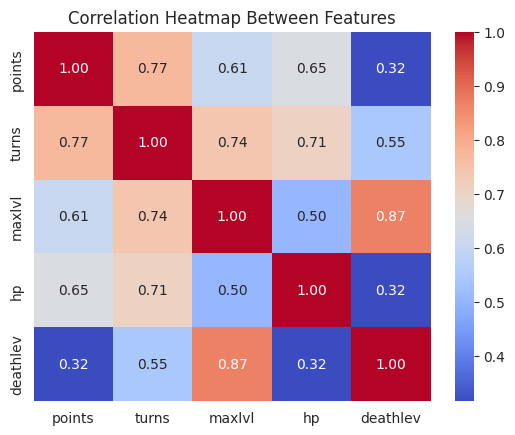

In [15]:
corr = data[['points', 'turns', 'maxlvl', 'hp', 'deathlev']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Between Features')
plt.show()

In [16]:
# TODO: Build classifier to predict ascended property of player
# Can fine tune this to predict likliehood of ascension given multiple play-throughs? 
# Build train/test dataset 
# Start with most simple parameters that are highly correlated to success (ie, num. turns, num. points, 

# Combine DataFrames
# df_main = pd.concat([ascended_df, non_ascended_df])
# # Sort by name
# df_main = df_main.sort_values(by='name')
# print(df_main)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode
data['death_encoded'] = data['death'].map({'ascended': 1}).fillna(0).astype(int)


X = data[['points', 'turns', 'maxlvl', 'hp']]  # Features
y = data['death_encoded']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classification
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[1880]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1880

    accuracy                           1.00      1880
   macro avg       1.00      1.00      1.00      1880
weighted avg       1.00      1.00      1.00      1880



/code/persistence/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming ascended_df is your DataFrame containing all the data

# Create a binary target variable
data['death_encoded'] = data['death'].map({'ascended': 1}).fillna(0).astype(int)

# Create lagged features
data['prev_game_ascended'] = data.groupby('name')['death_encoded'].shift(1).fillna(0)

# Create additional features
data['avg_points'] = data.groupby('name')['points'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['maxlvl_prev'] = data.groupby('name')['maxlvl'].shift(1).fillna(0)

# Drop rows where lagged features are missing
data.dropna(subset=['prev_game_ascended', 'avg_points', 'maxlvl_prev'], inplace=True)

# Define features and target variable
X = data[['prev_game_ascended', 'avg_points', 'maxlvl_prev', 'turns', 'hp']]  # Add more features as needed
y = data['death_encoded']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Encode the 'death' column into a binary outcome
data['death_encoded'] = data['death'].map({'ascended': 1}).fillna(0).astype(int)

# Create lagged features and aggregate statistics
data['prev_game_ascended'] = data.groupby('name')['death_encoded'].shift(1).fillna(0)
data['avg_points'] = data.groupby('name')['points'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['maxlvl_prev'] = data.groupby('name')['maxlvl'].shift(1).fillna(0)

# Drop rows with missing lagged features
data.dropna(subset=['prev_game_ascended', 'avg_points', 'maxlvl_prev'], inplace=True)

# Define features and target variable
X = data[['prev_game_ascended', 'avg_points', 'maxlvl_prev', 'turns', 'hp']]  # Add more features as needed
y = data['death_encoded']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.999468085106383
Confusion Matrix:
 [[1879    0]
 [   1    0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1879
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1880
   macro avg       0.50      0.50      0.50      1880
weighted avg       1.00      1.00      1.00      1880



/code/persistence/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/code/persistence/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/code/persistence/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
subselect_sql = "SELECT gameid FROM games WHERE gameid=?"
subselect_sql_args = ("6166456",)

batch_size = 1

# Build the dataset
player83 = nld.TtyrecDataset(
    "nld-nao",
    batch_size=batch_size,
    seq_length=453860,
    dbfilename=dbfilename,
    subselect_sql=subselect_sql,
    subselect_sql_args=subselect_sql_args
)

# No Error found - Correct build 
print(f"Persistent Player has: {len(player83._gameids)}")

mb = next(iter(player83))
    
# batch_idx = 0
# time_idx = 55
# 
# chars = mb['tty_chars'][batch_idx, time_idx]
# colors = mb['tty_colors'][batch_idx, time_idx]
# cursor = mb['tty_cursor'][batch_idx, time_idx]
# 
# game_id = mb['gameids'][batch_idx, time_idx]
# 
# print(tty_render(chars, colors, cursor))
# dict(player83.get_meta(game_id))

Persistent Player has: 1


In [ ]:
batch_idx = 0
time_idx = 453855

chars = mb['tty_chars'][batch_idx, time_idx]
colors = mb['tty_colors'][batch_idx, time_idx]
cursor = mb['tty_cursor'][batch_idx, time_idx]

game_id = mb['gameids'][batch_idx, time_idx]

print(tty_render(chars, colors, cursor))

In [ ]:
import time
from IPython.display import clear_output

for time_idx in range(0,20):
    chars = mb['tty_chars'][batch_idx, time_idx]
    colors = mb['tty_colors'][batch_idx, time_idx]
    cursor = mb['tty_cursor'][batch_idx, time_idx]
    # Render the current game state
    rendered_output = tty_render(chars, colors, cursor)
    print(rendered_output)

In [8]:
import time
from IPython.display import clear_output

# Function to clear the screen
def clear_screen():
    os.system('cls' if os.name == 'nt' else 'clear')

# Function to animate the tty_chars
def animate_tty_chars(minibatch, delay=0.1):

    for time_idx in range(0,100):
        chars = minibatch['tty_chars'][0, time_idx]  # Get the first batch
        colors = minibatch['tty_colors'][0, time_idx]
        cursor = minibatch['tty_cursor'][0, time_idx]
        # clear_output(wait=True)
        
        # Render the current game state
        rendered_output = tty_render(chars, colors, cursor)
        print(rendered_output)
        time.sleep(delay)


# Animate the tty_chars with a delay of 0.1 seconds between frames
animate_tty_chars(mb, delay=.1)

In [54]:
batch_idx = 0
time_idx = 35

chars = mb['tty_chars'][batch_idx, time_idx]
colors = mb['tty_colors'][batch_idx, time_idx]
cursor = mb['tty_cursor'][batch_idx, time_idx]

game_id = mb['gameids'][batch_idx, time_idx]

output = tty_render(chars, colors, cursor) 

lines = output.split('\n')

if lines:
    print(lines[1])

# parsed_output = parse_output(output)

31 gold pieces.                                                                 


/tmp/ipykernel_8323/2624162883.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['starttime'] = pd.to_datetime(player_data['starttime'], unit='s')


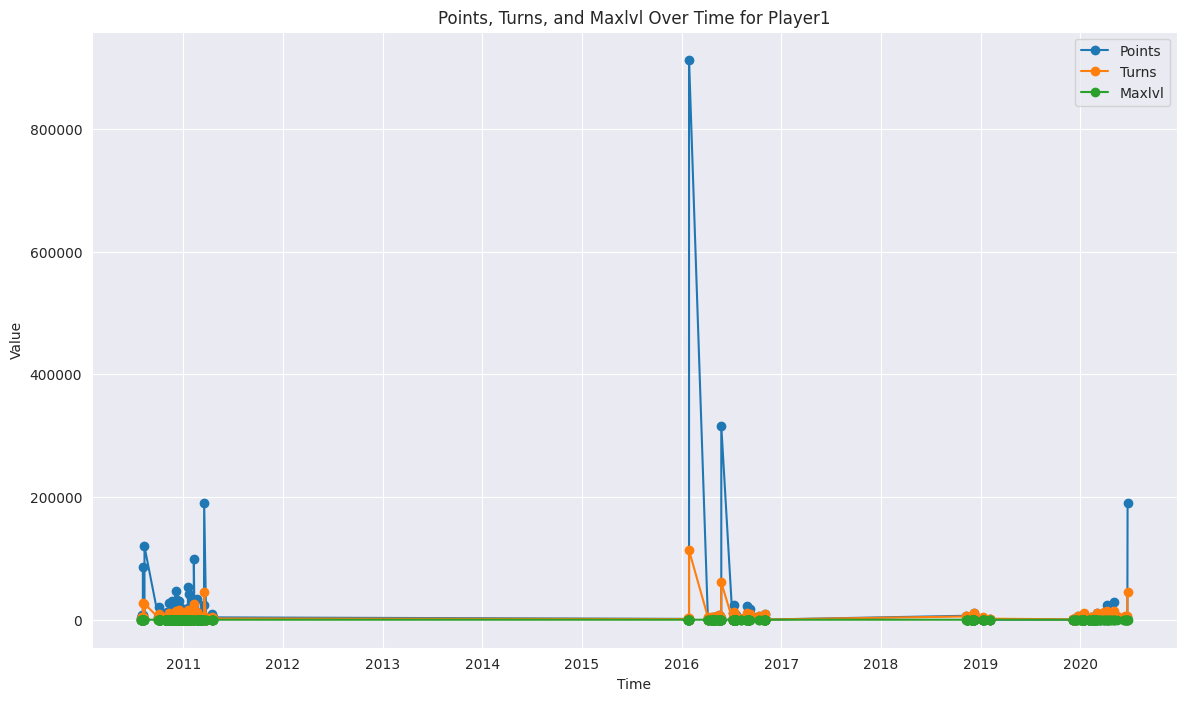

In [57]:
# Step 1: Filter data for the specific player
player_name = 'Player1'  # Replace with the desired player's name
player_data = data[data['name'] == player_name]

# Step 2: Convert starttime to datetime
player_data['starttime'] = pd.to_datetime(player_data['starttime'], unit='s')

# Step 3: Plot Points, Turns, and Maxlvl over time
plt.figure(figsize=(14, 8))

# Plot Points
plt.plot(player_data['starttime'], player_data['points'], marker='o', label='Points')

# Plot Turns
plt.plot(player_data['starttime'], player_data['turns'], marker='o', label='Turns')

# Plot Maxlvl
plt.plot(player_data['starttime'], player_data['maxlvl'], marker='o', label='Maxlvl')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Points, Turns, and Maxlvl Over Time for {player_name}')
plt.legend()

# Display the plot
plt.show()

/tmp/ipykernel_8323/2922816594.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='role', y='points', data=data, palette="Set3", width=0.6, showfliers=True)


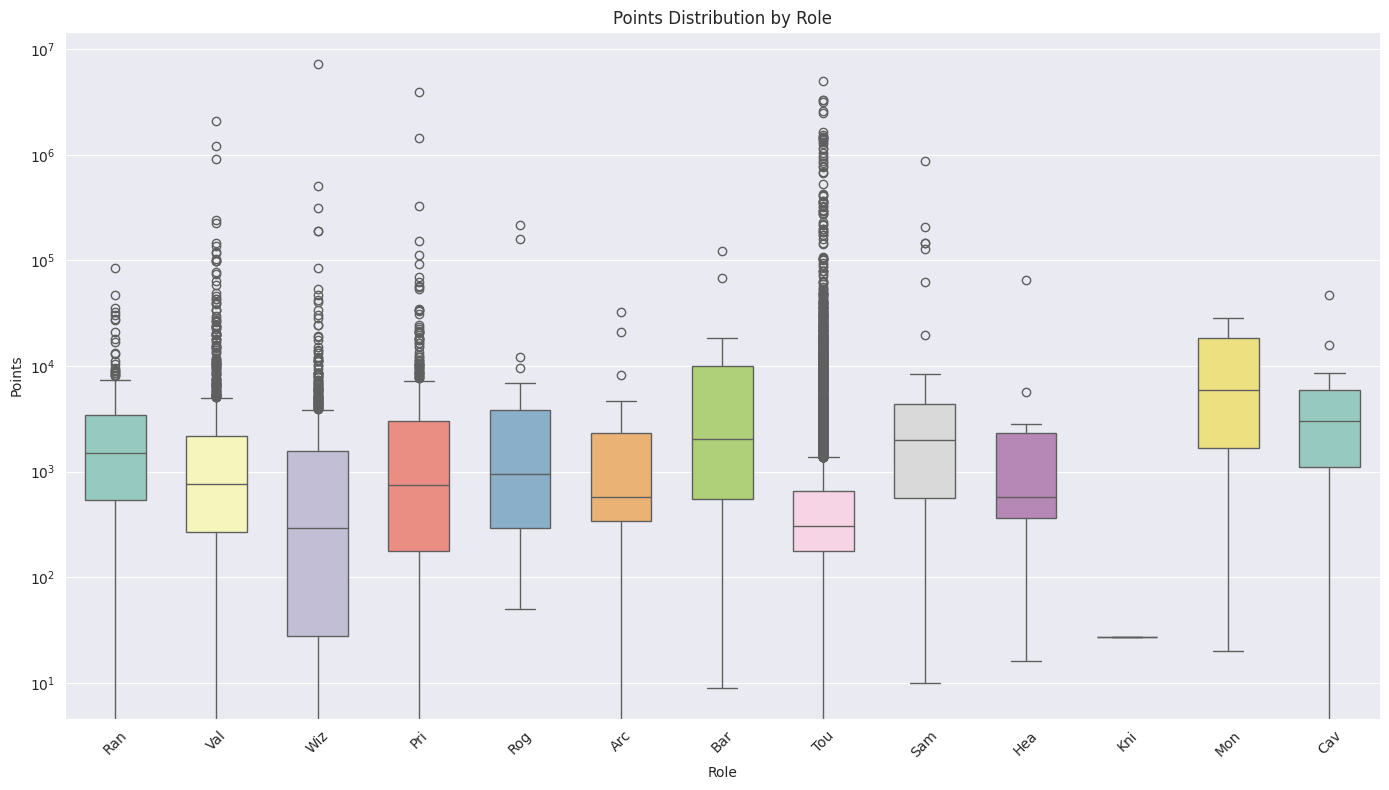

In [59]:
plt.figure(figsize=(14, 8))

# Create the box plot
sns.boxplot(x='role', y='points', data=data, palette="Set3", width=0.6, showfliers=True)

# Optionally apply a logarithmic scale to the y-axis if the points have a large range
plt.yscale('log')

# Customize the plot
plt.xlabel('Role')
plt.ylabel('Points')
plt.title('Points Distribution by Role')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_8323/4286332955.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='role', y='maxlvl', data=data, palette="Set3", width=0.6, showfliers=True)


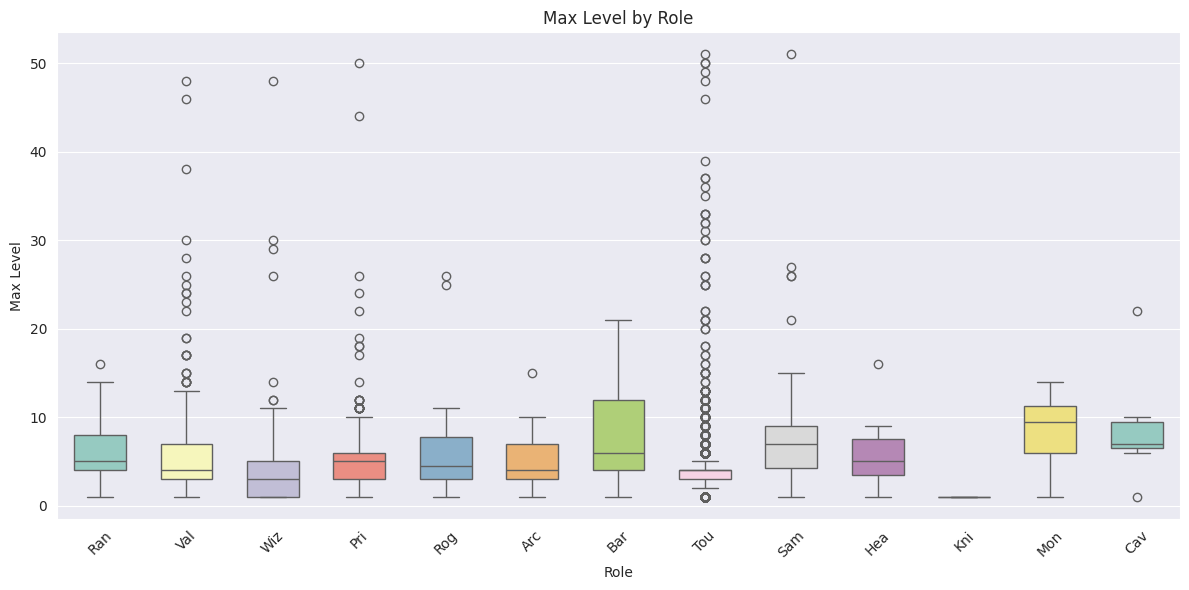

In [65]:
plt.figure(figsize=(12, 6))

# Create the box plot
sns.boxplot(x='role', y='maxlvl', data=data, palette="Set3", width=0.6, showfliers=True)



# Customize the plot
plt.xlabel('Role')
plt.ylabel('Max Level')
plt.title('Max Level by Role')
plt.xticks(rotation=45)  
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'points_min'

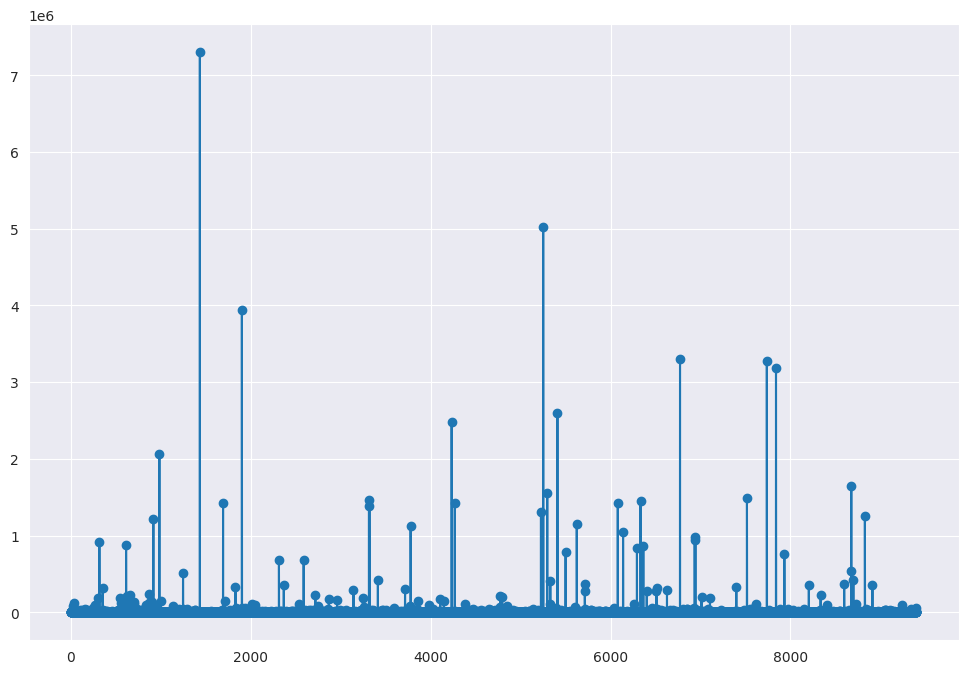

In [66]:
# Create a plot for the points statistics
plt.figure(figsize=(12, 8))

# Plot mean points
plt.plot(data.index, data['points'], label='Mean Points', marker='o')

# Plot min points
plt.plot(data.index, data['points_min'], label='Min Points', marker='o')

# Plot max points
plt.plot(data.index, data['points_max'], label='Max Points', marker='o')

# Add titles and labels
plt.title('Player Points Statistics')
plt.xlabel('Player')
plt.ylabel('Points')
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_8323/2793245724.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y='points', data=data, palette="Set3", width=0.6, showfliers=True)


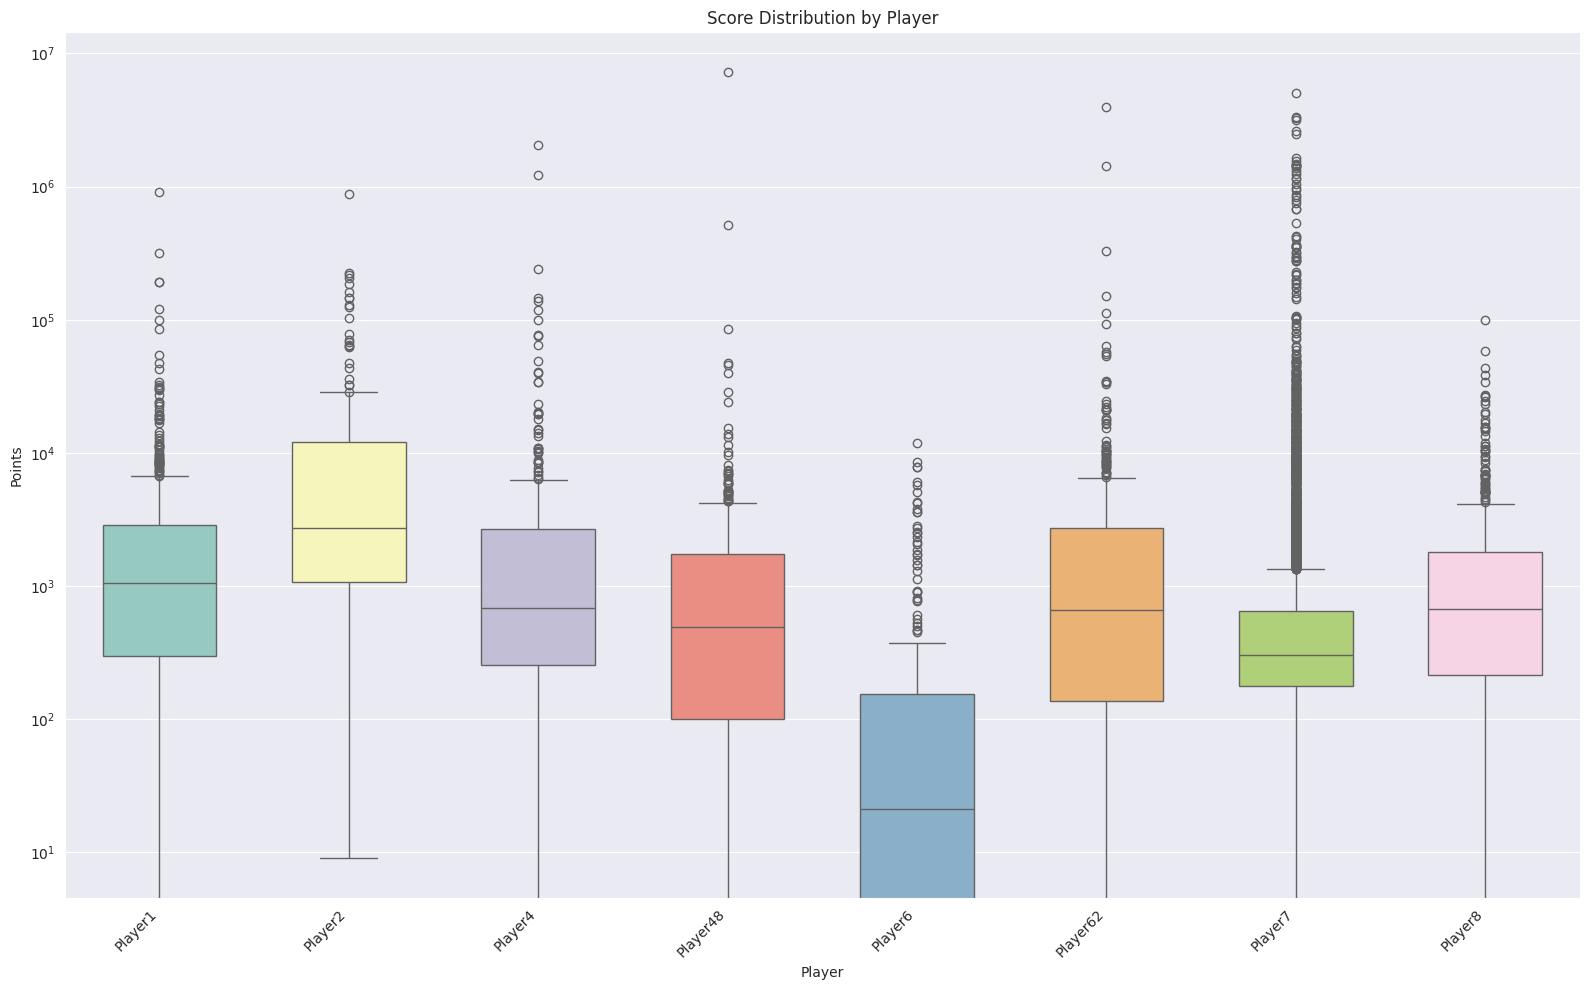

In [71]:

# Increase figure size for better spacing
plt.figure(figsize=(16, 10))

# Create the box plot
sns.boxplot(x='name', y='points', data=data, palette="Set3", width=0.6, showfliers=True)

# Customize the plot
plt.xlabel('Player')
plt.ylabel('Points')
plt.title('Score Distribution by Player')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Apply a logarithmic scale if needed
plt.yscale('log')

# Adjust layout to fit everything nicely
plt.tight_layout()

# Show the plot
plt.show()

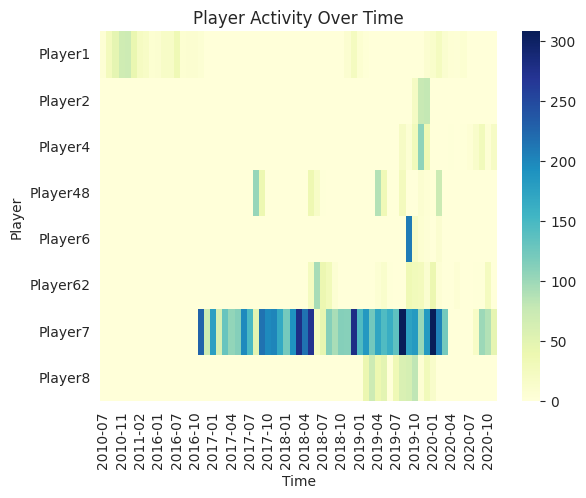

In [72]:
data['year_month'] = data['starttime'].dt.to_period('M')  # Convert to year-month period
games_per_month = data.groupby(['name', 'year_month']).size().unstack(fill_value=0)
sns.heatmap(games_per_month, cmap="YlGnBu")
plt.title('Player Activity Over Time')
plt.xlabel('Time')
plt.ylabel('Player')
plt.show()

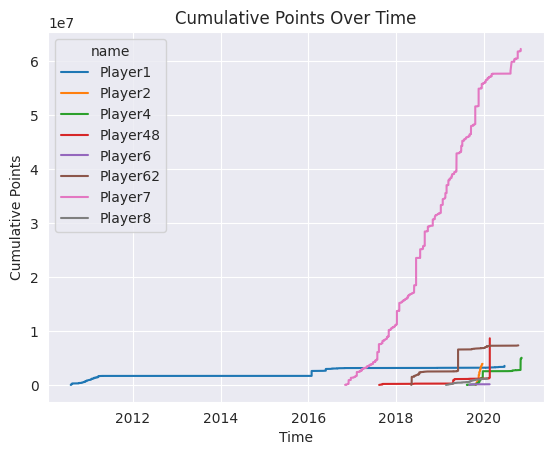

In [73]:
data['cumulative_points'] = data.groupby('name')['points'].cumsum()
sns.lineplot(x='starttime', y='cumulative_points', hue='name', data=data)
plt.title('Cumulative Points Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Points')
plt.show()

/tmp/ipykernel_8323/2257278789.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='name', y='turns', data=data, palette="Set2")


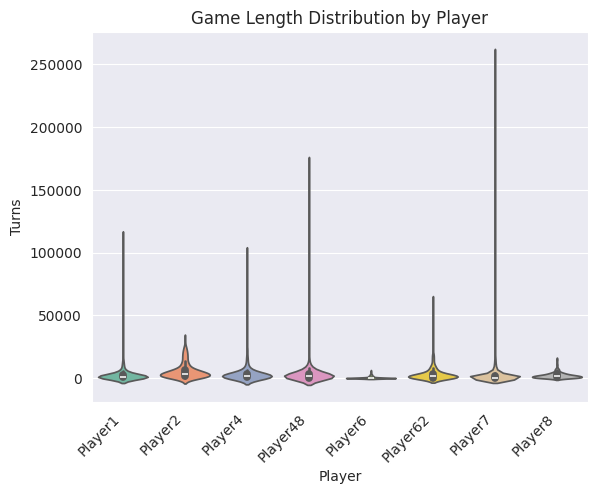

In [76]:
sns.violinplot(x='name', y='turns', data=data, palette="Set2")
plt.title('Game Length Distribution by Player')
plt.xlabel('Player')
plt.ylabel('Turns')
plt.xticks(rotation=45, ha='right')
plt.show()

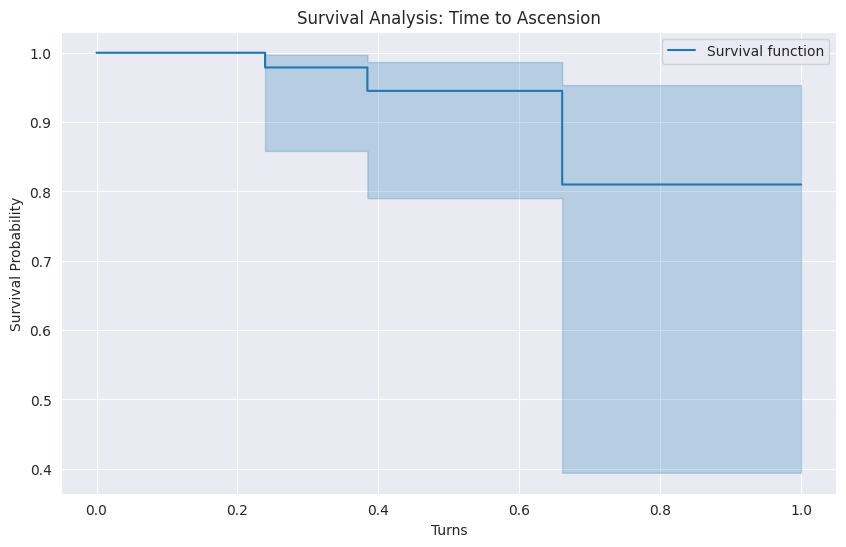

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference_y,death_encoded
0,4085412,3.4.3,0.000286,2,4,4,0.049731,32,1,20100730,...,0.004454,0x0,2308,2010-07-30 08:23:27,2010-07-30 09:02:23,Fem,Cha,-1,3896 days 06:03:18,0
1,4086650,3.4.3,0.000020,0,2,3,0.026882,14,1,20100731,...,0.001153,0x0,851,2010-07-30 09:02:50,2010-07-31 17:39:29,Fem,Cha,-1,3896 days 06:03:18,0
2,4086653,3.4.3,0.000000,0,1,1,0.048387,14,1,20100731,...,0.000019,0x0,50,2010-07-31 17:39:41,2010-07-31 17:40:35,Fem,Cha,-1,3896 days 06:03:18,0
3,4086664,3.4.3,0.000247,2,5,5,0.049731,32,1,20100731,...,0.008611,0x0,2288,2010-07-31 17:40:43,2010-07-31 18:18:57,Fem,Cha,-1,3896 days 06:03:18,0
4,4086668,3.4.3,0.000026,0,1,2,0.049731,14,1,20100731,...,0.001730,0x0,309,2010-07-31 18:19:02,2010-07-31 18:24:20,Fem,Cha,-1,3896 days 06:03:18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,39721,3.6.4,0.000170,0,4,4,0.049731,50,1,20200123,...,0.007999,0x0,671,2020-01-23 23:13:30,2020-01-23 23:24:41,Fem,Law,0x4,344 days 01:55:27,0
9396,41927,3.6.4,0.000077,0,3,4,0.049731,35,1,20200128,...,0.006134,0x0,587,2020-01-28 23:35:00,2020-01-28 23:44:47,Fem,Law,0x4,344 days 01:55:27,0
9397,41967,3.6.4,0.000319,2,5,5,0.049731,52,1,20200129,...,0.010507,0x0,2885,2020-01-28 23:44:52,2020-01-29 00:32:59,Fem,Law,0x4,344 days 01:55:27,0
9398,42511,3.6.4,0.000385,2,5,5,0.049731,59,1,20200129,...,0.014946,0x0,1693,2020-01-29 19:13:28,2020-01-29 19:41:42,Fem,Law,0x4,344 days 01:55:27,0


In [22]:
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Fit the survival model
kmf.fit(durations=data['turns'], event_observed=data['death_encoded'], label="Survival function")

# Plot the survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

# Customize the plot
plt.title('Survival Analysis: Time to Ascension')
plt.xlabel('Turns')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

data

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Index by Time
data = data.sort_values(['name', 'starttime'])

# Feature Selection
features = ['points', 'turns', 'hp']  
target = 'deathlev'  # Dungeon level

# Normalization
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Sequence Size
sequence_length = 10 
def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    for player in data['name'].unique():
        player_data = data[data['name'] == player]
        for i in range(len(player_data) - sequence_length):
            X.append(player_data[features].iloc[i:i+sequence_length].values)
            y.append(player_data[target].iloc[i+sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data, features, target, sequence_length)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Model Building 
model = Sequential()

# LSTM layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

model.summary()

I0000 00:00:1724266190.064092    9676 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 11:49:50.405030: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/code/persistence/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15.1932 - val_loss: 13.1140
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.0536 - val_loss: 13.1741
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6359 - val_loss: 13.1415
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2611 - val_loss: 13.1044
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4505 - val_loss: 13.1009
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.6817 - val_loss: 13.2249
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.3363 - val_loss: 13.1322
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7935 - val_loss: 13.3346
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.0818 - val_loss: 13.1246
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3009 - val_loss: 13.1761
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6155 - val_loss: 13.1358
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━

In [20]:
# Model Evaluation
y_pred = model.predict(X_test)

# Discretize Dugeeon Levels 
y_pred = np.round(y_pred).astype(int)

# RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f'RMSE: {rmse}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 3.2703637366441494
